In [21]:
import pandas as pd
import matplotlib.pylab as plt
import matplotlib as mpl
import numpy as np
from matplotlib.patches import Circle, Rectangle, Arc
import seaborn as sns
plt.style.use('seaborn-dark-palette')
mypal = plt.rcParams['axes.prop_cycle'].by_key()['color'] # Grab the color pal
import os
import gc
from collections import Counter

In [22]:
cd ../data

/Users/johnwalecka/Desktop/Springboard/march_madness/march_madness_repo/data


In [23]:
events = pd.read_csv('events_2015.csv', index_col='EventID')
team_ids = pd.read_csv('teams.csv', index_col='TeamID')
games = pd.read_csv('MRegularSeasonCompactResults.csv', index_col='Season').loc['2015']
rankings = pd.read_csv('MMasseyOrdinals.csv', index_col='Season').loc['2015']

/Users/johnwalecka/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [24]:
games.index = range(len(games))
final_rankings = rankings[(rankings['RankingDayNum'] == 133) & (rankings['SystemName'] == '7OT')].pivot_table(index='TeamID', values='OrdinalRank')
for index, row in games.iterrows():
    games.loc[index, 'WTeamRank'] = int(final_rankings.loc[games.iloc[index, 1]])
    games.loc[index, 'LTeamRank'] = int(final_rankings.loc[games.iloc[index, 3]])


In [25]:
def get_ppg(ppg_wins, num_wins, ppg_loss, num_loss):
    if num_wins == 0:
        return ppg_loss
    if num_loss == 0:
        return ppg_wins
    else:
        return (ppg_wins*num_wins + ppg_loss*num_loss)/(num_wins + num_loss)
    

In [26]:
basic_stats_dist = final_rankings.copy()
for index, row in basic_stats_dist.iterrows():
    wins = len(games[games['WTeamID'] == index])
    losses = len(games[games['LTeamID'] == index])
    basic_stats_dist.loc[index, 'wins'] = wins
    basic_stats_dist.loc[index, 'losses'] = losses
    basic_stats_dist.loc[index, 'win_pct'] = basic_stats_dist.loc[index, 'wins']/(basic_stats_dist.loc[index, 'wins'] + basic_stats_dist.loc[index, 'losses'])
    basic_stats_dist.loc[index, 'win_top50'] = len(games[(games['WTeamID'] == index) & (games['LTeamRank'] <= 50)])
    win_ppg_scored = games[games['WTeamID'] == index].WScore.mean()
    loss_ppg_scored = games[games['LTeamID'] == index].LScore.mean()
    win_ppg_allowed = games[games['WTeamID'] == index].LScore.mean()
    loss_ppg_allowed = games[games['LTeamID'] == index].WScore.mean()
    basic_stats_dist.loc[index, 'win_ppg_scored'] = win_ppg_scored
    basic_stats_dist.loc[index, 'loss_ppg_scored'] = loss_ppg_scored
    basic_stats_dist.loc[index, 'ppg_scored'] = get_ppg(win_ppg_scored, wins, loss_ppg_scored, losses)
    basic_stats_dist.loc[index, 'win_ppg_allowed'] = win_ppg_allowed
    basic_stats_dist.loc[index, 'loss_ppg_allowed'] = loss_ppg_allowed
    basic_stats_dist.loc[index, 'ppg_allowed'] = get_ppg(win_ppg_allowed, wins, loss_ppg_allowed, losses)
basic_stats_dist = basic_stats_dist.sort_values(by='OrdinalRank', ascending=True)


In [27]:
events['counter'] = 1

In [28]:
team_shot_counters = dict()
for index in team_ids.index:
    if ((index in events.WTeamID.values) or (index in events.LTeamID.values)):
        shot_list = list(events[events.EventTeamID == index]['EventType'])
        dist_dict = Counter(shot_list)
        team_shot_counters[index] = dist_dict

In [29]:
shot_dist = final_rankings.copy()
inf = 1000000
for team_id, shot_counter in team_shot_counters.items():
    made_1 = shot_counter.get('made1', 0)
    miss_1 = shot_counter.get('miss1', 0)
    made_2 = shot_counter.get('made2', 0)
    miss_2 = shot_counter.get('miss2', 0)
    made_3 = shot_counter.get('made3', 0)
    miss_3 = shot_counter.get('miss3', 0)
    total_attempted = made_1 + miss_1 + made_2 + miss_2 + made_3 + miss_3
    total_made = made_1 + made_2 + made_3
    
    shot_dist.loc[team_id, 'ones_attempted_pct'] = (miss_1 + made_1)/total_attempted
    shot_dist.loc[team_id, 'ones_made_pct'] = made_1/total_made
    shot_dist.loc[team_id, 'twos_attempted_pct'] = (miss_2 + made_2)/total_attempted
    shot_dist.loc[team_id, 'twos_made_pct'] = made_2/total_made
    shot_dist.loc[team_id, 'threes_attempted_pct'] = (miss_3 + made_3)/total_attempted
    shot_dist.loc[team_id, 'threes_made_pct'] = made_3/total_made
    
shot_dist.sort_values(by='OrdinalRank', ascending=True)
    

,OrdinalRank,ones_attempted_pct,ones_made_pct,twos_attempted_pct,twos_made_pct,threes_attempted_pct,threes_made_pct
TeamID,,,,,,,
1246,1,0.304882,0.405086,0.506951,0.474867,0.188167,0.120047
1458,2,0.268779,0.368858,0.457102,0.451819,0.274119,0.179324
1211,3,0.283358,0.345679,0.485337,0.489929,0.231305,0.164392
1181,4,0.284998,0.355902,0.474106,0.476932,0.240895,0.167166
1112,5,0.320184,0.409596,0.503616,0.477472,0.176200,0.112932
...,...,...,...,...,...,...,...
1251,347,0.285641,0.408205,0.511795,0.465641,0.202564,0.126154
1146,348,0.282148,0.385932,0.455959,0.427757,0.261894,0.186312
1290,349,0.248230,0.357950,0.547600,0.505647,0.204170,0.136403


In [30]:
metrics_df = pd.concat([basic_stats_dist, shot_dist], axis=1)

In [31]:
basic_stats_dist['TeamID'] = basic_stats_dist.index
metrics_df = pd.merge(basic_stats_dist, shot_dist, how="inner").set_index('TeamID')

In [32]:
metrics_df.head()

,OrdinalRank,wins,losses,win_pct,win_top50,win_ppg_scored,loss_ppg_scored,ppg_scored,win_ppg_allowed,loss_ppg_allowed,ppg_allowed,ones_attempted_pct,ones_made_pct,twos_attempted_pct,twos_made_pct,threes_attempted_pct,threes_made_pct
TeamID,,,,,,,,,,,,,,,,,
1246,1,34.0,0.0,1.000000,14.0,74.911765,NaN,74.911765,53.970588,NaN,53.970588,0.304882,0.405086,0.506951,0.474867,0.188167,0.120047
1458,2,31.0,3.0,0.911765,9.0,72.870968,61.666667,71.882353,54.903226,68.666667,56.117647,0.268779,0.368858,0.457102,0.451819,0.274119,0.179324
1211,3,31.0,2.0,0.939394,9.0,78.967742,66.500000,78.212121,60.548387,69.500000,61.090909,0.283358,0.345679,0.485337,0.489929,0.231305,0.164392
1181,4,29.0,4.0,0.878788,12.0,81.862069,71.500000,80.606061,63.310345,82.000000,65.575758,0.284998,0.355902,0.474106,0.476932,0.240895,0.167166
1112,5,31.0,3.0,0.911765,6.0,77.354839,67.000000,76.441176,57.516129,70.000000,58.617647,0.320184,0.409596,0.503616,0.477472,0.176200,0.112932


In [51]:
def create_scatterplot(metric_x, metric_y):
    x = metrics_df[metric_x]
    y = metrics_df[metric_y]
    total_points = len(x)
    split = int(total_points/2)
    x_mean = x.mean()
    y_mean = y.mean()
    #plt.plot(x, x, color='grey', linestyle='dashed', linewidth=1)
    x_top = x.head(split)
    y_top = y.head(split)
    plt.plot(x_top, y_top, 'o', color='blue')
    x_bottom = x.tail(split)
    y_bottom = y.tail(split)
    plt.plot(x_bottom, y_bottom, 'o', color='purple')
    plt.axvline(x=x_mean, color='grey', linestyle='dashed', linewidth=1)
    plt.axhline(y=y_mean, color='grey', linestyle='dashed', linewidth=1)
    plt.xlabel(metric_x)
    plt.ylabel(metric_y)
    plt.show()

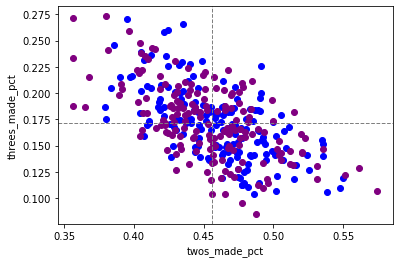

<Figure size 432x288 with 0 Axes>

In [53]:
create_scatterplot('twos_made_pct', 'threes_made_pct')
plt.savefig('foo.jpeg', bbox_inches='tight')

In [ ]:
def create_breakdown_dict(metric_df):
    breakdown_dict = dict()
    top_50_list = list()
    bottom_50_list = list()
    breakdown_len = int(len(metric_df)/2)
    for column in metric_df:
        top_teams_value = metric_df.head(breakdown_len)[column].mean()
        bottom_teams_value = metric_df.tail(breakdown_len)[column].mean()
        top_50_list.append(top_teams_value)
        bottom_50_list.append(bottom_teams_value)
    breakdown_dict['top_50_percentile'] = top_50_list
    breakdown_dict['bottom_50_percentile'] = bottom_50_list
    return breakdown_dict

In [ ]:
breakdown_dict = create_breakdown_dict(metrics_df)
breakdown_df = pd.DataFrame.from_dict(breakdown_dict, orient='index', columns = metrics_df.columns)
breakdown_df['ppg_scored'].plot(kind='bar')

In [ ]:
events.groupby('EventType')['counter'].sum().sort_values(ascending=False).plot(kind='bar',
          figsize=(15, 5),
         color=mypal[2],
         title='Event Type Frequency (Mens)')
plt.xticks(rotation=0)
plt.show()